# 準備

In [1]:
!nvidia-smi
# 16280MiBじゃなかったら16epochで動かないので文字数を512から減らす処理が必要

Mon Oct 11 03:30:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install transformers

In [3]:
import os
import sys
import math
from math import exp
import random
import time
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim import lr_scheduler
from transformers import AutoTokenizer,AutoModel,AutoModelForSequenceClassification,AdamW
from sklearn.metrics import fbeta_score
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm
from scipy.optimize import minimize, minimize_scalar

import nltk
nltk.download("punkt")
from nltk import word_tokenize
from nltk.corpus import stopwords 

import re

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
DATA_DIR = "Data/"
OUTPUT_DIR = "Output/"
LOG_DIR = "log/"
MODEL_DIR = "Model/"
Proba_DIR = 'Proba/'
warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
%cd /content/drive/MyDrive/Colab Notebooks/Signate論文コンペ

/content/drive/MyDrive/Colab Notebooks/Signate論文コンペ


In [7]:
def init_logger(log_file=LOG_DIR + "BERT.log"):
    from logging import INFO, FileHandler, Formatter, StreamHandler, getLogger

    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()

In [8]:
def seed_torch(seed = 42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed = 471
seed_torch(seed)

# データ処理関数の定義

In [9]:
def get_train_data(train):
    # 交差検証用の番号を振ります。
    Fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    for n, (train_index, val_index) in enumerate(Fold.split(train, train["judgement"])):
        train.loc[val_index, "fold"] = int(n)
    train["fold"] = train["fold"].astype(np.uint8)

    return train

In [10]:
def covid(text):
  text = str.lower(text)
  text = text.replace("covid-19", "coronavirus")
  text = text.replace("covid19", "coronavirus")
  text = text.replace("covi19", "coronavirus")
  text = text.replace("sars-cov-2", "coronavirus")
  text = text.replace("covid", "coronavirus")
  text = text.replace("rt-pcr", "pcr")
  text = text.replace("rt-qpcr", "pcr")
  text = text.replace("jc virus", "polyomavirus")
  text = text.replace("c virus", "herpesvirus")

  return text

In [11]:
import nltk
from nltk.corpus import stopwords 
nltk.download("stopwords")
nltk_stopwords=stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
nltk.download("stopwords")
nltk_stopwords = stopwords.words("english")

def stopword(text):
  # 不要な文字の削除
  text = re.findall('\W|\w+', text)
  text = ' '.join(text)
  text = text.replace('  ', ' ')
  text = re.sub(r"[0-9]", "",text)
  text = word_tokenize(text)

  stop_words = nltk_stopwords + ["(",")",">", "<","*", ":", ";","\\", "_", "%","Copyright",".","\"","'", "=", "?","!","a","l",",","-","@","&","^","/","%","[","]"]
  text = [t for t in text if t not in stop_words]
  text=" ".join(text)

  return text
  

def New_sep(text):
  # 文末のカンマのみをNEW_SEPに変えます
  text = text.replace(". ","[NEW_SEP]")
  
  return text


def New_sep_2(text):
  # 見栄えをよくします
  text = text.replace("new_sep","[NEW_SEP]")

  return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 前処理を少し詳しく
まず最初にNew_sep関数で文末のカンマのみを変更します。（数字間のピリオドなどを認識させないため）  
次に通常の前処理を行うと"[NEW_SEP]"がnew_sepになっています。  
最後にnew_sepを元に戻すNew_sep_2を行います。

# データの読み込み

In [13]:
train_data = pd.read_csv(DATA_DIR+'train.csv', encoding='utf8')
test_data = pd.read_csv(DATA_DIR+'test.csv', encoding='utf8')

train_data['text'] = train_data['title'] + ' ' + train_data['abstract'].fillna('')
test_data['text'] = test_data['title'] + ' ' + test_data['abstract'].fillna('')

train = train_data.drop(columns=['title', 'abstract'])
test = test_data.drop(columns=['title', 'abstract'])

sub = pd.read_csv(DATA_DIR+"sample_submit.csv", header=None)
sub.columns = ["id","judgement"]

In [14]:
# foldを振り分ける
train=get_train_data(train)

In [15]:
train['fold'].value_counts().sort_index()

0    5429
1    5429
2    5429
3    5429
4    5429
Name: fold, dtype: int64

## BERTの種類
- SciBert … 科学論文に特化した単語で学習したBERTモデル 評価指標無し  
"allenai/scibert_scivocab_uncased"
- PubmedBert … Microsoftが作成した、生物医学論文のテキストを学習したBERTモデル 最高精度- LB:0.9114,CV 0.898 
 "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract"
- COVID-SciBert … SciBertをベースにコロナウイルスの医学論文テキストを学習させたBERTモデル 評価指標無し　  
"lordtt13/COVID-SciBERT"
-BioELECTRA…生物医学領域、Pubmedで事前学習している  
"kamalkraj/bioelectra-base-discriminator-pubmed"

# インプットする文字の長さ測定

In [16]:
# train_data["text"] = train_data["text"].apply(New_sep)
# test_data["text"] = test_data["text"].apply(New_sep)
# train_data["text"] = train_data["text"].apply(covid)
# test_data["text"] = test_data["text"].apply(covid)
# train_data["text"] = train_data["text"].apply(stopword)
# test_data["text"] = test_data["text"].apply(stopword)
# train_data["text"] = train_data["text"].apply(New_sep_2)
# test_data["text"] = test_data["text"].apply(New_sep_2)

In [17]:
#tokenを調べて出力したい
#tokenizer=AutoTokenizer.from_pretrained("kamalkraj/bioelectra-base-discriminator-pubmed")
#tokenizer.add_tokens(["[NEW_SEP]"], special_tokens=True)

#tokenリストを出力
#pd.DataFrame(tokenizer.vocab.keys(), columns=['token']).to_csv('Token/'+'kamalkraj_bioelectra-base-discriminator-pubmed_token_list.csv')

In [18]:
# max_lens_train=[]
# i=0
# j=0
# max_len=512 # 任意に設定

# for x in train_data["text"]:
#     max_lens_train.append(len(tokenizer.tokenize(x)))
#     max_lens=(len(tokenizer.tokenize(x)))
#     if max_lens >=max_len:
#         i+=1        
# max_lens_test=[]
# for x in test_data["text"]:
#     max_lens_test.append(len(tokenizer.tokenize(x)))
#     max_lens=(len(tokenizer.tokenize(x)))
#     if max_lens >=max_len:
#         j+=1
# print("トークンの最大値：{},trainの文字数{}オーバーは{}個です".format(max(max_lens_train),max_len,i))
# print("トークンの最大値：{},testの文字数{}オーバーは{}個です".format(max(max_lens_test),max_len,j))

In [19]:
# # 分布を出力
# fig,(ax1,ax2)=plt.subplots(2,1,figsize=(15,7))

# sns.histplot(max_lens_train, ax = ax1, label = "train")
# ax1.legend(loc="lower right",fontsize=30)
# ax1.set_xlabel(xlabel="lens")
# ax1.grid()
# ax1.set_title("train",fontsize=10)
# ax1.set_xlim(1,800)
# ax1.legend(loc='upper right',fontsize=10)

# sns.histplot(max_lens_test, ax = ax2, label = "test")
# ax2.legend(loc="lower right",fontsize=20)
# ax2.set_xlabel(xlabel="lens")
# ax2.grid()
# ax2.set_title("train",fontsize=10)
# ax2.set_xlim(1,800)
# ax2.legend(loc='upper right',fontsize=10)

# BERTに使う関数・クラスの定義

## データセット定義

In [20]:
class BaseDataset(Dataset):
    def __init__(self, df, model_name, include_labels=True):
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        tokenizer.add_tokens(["[NEW_SEP]"], special_tokens=True)
        self.df = df
        self.include_labels = include_labels
        df["text"] = df["text"].apply(New_sep)
        df["text"] = df["text"].apply(covid)
        df["text"] = df["text"].apply(stopword)
        df["text"] = df["text"].apply(New_sep_2)
        self.text = df["text"].tolist()
        self.encoded = tokenizer.batch_encode_plus(
            self.text,
            padding = "max_length",            
            max_length = 512,
            truncation = True,
            return_attention_mask = True,
            return_tensors = "pt"
        )
        if self.include_labels:
            self.labels = df["judgement"].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        input_ids = torch.tensor(self.encoded['input_ids'][idx])
        attention_mask = torch.tensor(self.encoded['attention_mask'][idx])

        if self.include_labels:
            label = torch.tensor(self.labels[idx]).float()
            return input_ids, attention_mask, label

        return input_ids, attention_mask

## モデル定義

In [21]:
class BaseModel(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        tokenizer.add_tokens(["[NEW_SEP]"], special_tokens=True)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                                        num_labels = 1,
                                                                        output_hidden_states = True)
        self.model.resize_token_embeddings(len(tokenizer))

    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids=input_ids,
                             attention_mask=attention_mask)        
        outputs = outputs.logits  

        return outputs

## ツール

In [22]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (remain %s)" % (asMinutes(s), asMinutes(rs))

In [23]:
def bestFbeta(labels,preds):
  # bestFbetaとThresholdを抽出
  Threshold_list = []
  fbeta_score_list = []
  for i in range(1000):
      Threshold = i*0.0001
      predictions = np.where(preds < Threshold, 0, 1)
      Threshold_list.append(Threshold)
      fbeta_score_list.append(fbeta_score(labels, predictions, beta=7.0))
  for i,j in zip(Threshold_list, fbeta_score_list):
    if j == max(fbeta_score_list):
      return i,j
      break

## 学習補助関数

In [24]:
def train_fn(train_loader, model, criterion, optimizer, epoch, device):
    start = end = time.time()
    losses = AverageMeter()
    sigmoid = nn.Sigmoid()

    # switch to train mode
    model.train()

    for step, (input_ids, attention_mask, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        outputs = model(input_ids, attention_mask)

        y_preds = sigmoid(outputs).squeeze()

        loss = criterion(y_preds, labels)
        # record loss
        losses.update(loss.item(), batch_size)
        loss.backward()

        optimizer.step()

        # ミニバッチ学習を128に変更する
        #if (step+1)%128==0:
        #  optimizer.step()
        #  optimizer.zero_grad()


        if step % 100 == 0 or step == (len(train_loader) - 1):
            print(
                f"Epoch: [{epoch + 1}][{step}/{len(train_loader)-1}] "
                f"Elapsed {timeSince(start, float(step + 1) / len(train_loader)):s} "
                f"Loss: {losses.avg:.4f} "
            )      

    return losses.avg

## 検証補助関数

In [25]:
def valid_fn(valid_loader, model, criterion, device):
    start = end = time.time()
    losses = AverageMeter()
    sigmoid = nn.Sigmoid()

    # switch to evaluation mode
    model.eval()
    preds = []

    for step, (input_ids, attention_mask, labels) in enumerate(valid_loader):
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        # compute loss
        with torch.no_grad():
            outputs = model(input_ids, attention_mask)

        y_preds = sigmoid(outputs).squeeze()

        if y_preds.size()==torch.Size([]):
          y_preds = y_preds.unsqueeze(-1)

        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # record score
        preds.append(y_preds.to("cpu").numpy())

        if step % 100 == 0 or step == (len(valid_loader) - 1):
            print(
                f"EVAL: [{step}/{len(valid_loader)-1}] "
                f"Elapsed {timeSince(start, float(step + 1) / len(valid_loader)):s} "
                f"Loss: {losses.avg:.4f} "
            )

    predictions = np.concatenate(preds)
    return losses.avg, predictions

## 推論関数

In [26]:
def inference():
    model_name = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract"
    predictions = []

    test_dataset = BaseDataset(test, model_name, include_labels=False)
    test_loader = DataLoader(test_dataset,
                             batch_size=16,
                             shuffle=False,
                             num_workers=4,
                             pin_memory=True)
    sigmoid = nn.Sigmoid()

    for fold in range(5):
        LOGGER.info(f"========== model {fold} inference ==========")
        model = BaseModel(model_name)
        model.to(device)
        model.load_state_dict(torch.load(MODEL_DIR + f"Pubmed_fold{fold}.pth")["model"])
        model.eval()
        preds = []

        for i, (input_ids, attention_mask) in tqdm(enumerate(test_loader), total=len(test_loader)):
          input_ids = input_ids.to(device)
          attention_mask = attention_mask.to(device)
          with torch.no_grad():
              outputs = model(input_ids, attention_mask)
          y_preds = sigmoid(outputs).squeeze()
          preds.append(y_preds.to("cpu").numpy())

        preds = np.concatenate(preds)
        predictions.append(preds)
    predictions = np.mean(predictions, axis=0)

    return predictions

## 学習関数

In [27]:
def train_loop(train, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")
    model_name = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract"
    batch = 16
    # ====================================================
    # Data Loader
    # ====================================================
    trn_idx = train[train["fold"] != fold].index
    val_idx = train[train["fold"] == fold].index

    train_folds = train.loc[trn_idx].reset_index(drop=True)
    valid_folds = train.loc[val_idx].reset_index(drop=True)

    train_dataset = BaseDataset(train_folds, model_name)
    valid_dataset = BaseDataset(valid_folds, model_name)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        drop_last=True,
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=batch,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
    )

    # ====================================================
    # Model
    # ====================================================
    model = BaseModel(model_name)
    model.to(device)
    criterion = nn.BCELoss()

    # ====================================================
    # Loop
    # ====================================================
    best_val_loss = 1
    best_loss = np.inf
    best_score = 0
    epochs = 3
    LR = 2e-5
    # LR = [2e-4, 2e-5, 2e-6]

    optimizer = AdamW(model.parameters(), lr=LR)

    #scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=3, T_mult=1, eta_min=0, last_epoch=-1, verbose=False)

    for epoch in range(epochs):
        #optimizer = AdamW(model.parameters(), lr=LR[epoch])
        start_time = time.time()
        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds["judgement"].values

        # scoring
        bestThr,score = bestFbeta(valid_labels, preds)

        elapsed = time.time() - start_time
        LOGGER.info(
            f"Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s"
        )
        LOGGER.info(f"Epoch {epoch+1} - Score: {score} - Threshold:{bestThr:.4f} - val_loss{avg_val_loss:.4f}")

        if best_score < score:  # or (if avg_val_loss < best_val_loss:)
            best_score = score
            best_val_loss = avg_val_loss
            best_Threshold = bestThr 
            LOGGER.info(f"Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model - bestThr{best_Threshold:.5f} - val_loss{best_val_loss:.4f}")
            torch.save(
                {"model": model.state_dict(), "preds": preds, "Threshold":best_Threshold}, MODEL_DIR + f"Pubmed_fold{fold}.pth"
            )

        #scheduler.step()

    check_point = torch.load(MODEL_DIR + f"Pubmed_fold{fold}.pth")

    valid_folds["preds"] = check_point["preds"]
    LOGGER.info(f"Bacthsize :{batch} - LearningRate :{LR}")
    return valid_folds, best_Threshold

In [28]:
def get_result(result_df,best_threshold):
    preds = result_df["preds"].values
    labels = result_df["judgement"].values
    score = fbeta_score(labels, preds >= best_threshold, beta=7)
    LOGGER.info(f"Score: {score:<.5f} - Threshold：{best_threshold:<.5f}")

## メイン（モデルのトレーニング〜testデータの予測）を行う関数

In [29]:
def main():
    # Training
    LOGGER.info("BERT PubMed Abstract")
    oof_df = pd.DataFrame()
    Threshold_list=[]
    for fold in range(5):
        _oof_df, best_Threshold = train_loop(train, fold)
        oof_df = pd.concat([oof_df, _oof_df])
        LOGGER.info(f"========== fold: {fold} result ==========")
        get_result(_oof_df,best_Threshold)
        Threshold_list.append(best_Threshold)
        Threshold_mean = np.mean(Threshold_list)
    # CV result
    LOGGER.info(f"========== CV ==========")
    get_result(oof_df,Threshold_mean)
    
    # Save OOF result
    oof_df.to_csv(OUTPUT_DIR + "oof_df.csv", index=False)

    # Inference
    predictions_sigmoid = inference()
    predictions = np.where(predictions_sigmoid < Threshold_mean, 0, 1)
    

    # submission
    sub["judgement"] = predictions
    sub.to_csv(OUTPUT_DIR + "submission.csv", index=False, header=False)
    LOGGER.info("==========CONPLETE==========")
    return predictions_sigmoid, predictions

## モデルのトレーニングのみを行う関数

In [30]:
def trainning():
    # Training
    LOGGER.info("BERT PubMed Abstract")
    oof_df = pd.DataFrame()
    Threshold_list=[]
    for fold in range(5):
        _oof_df, best_Threshold = train_loop(train, fold)
        oof_df = pd.concat([oof_df, _oof_df])
        LOGGER.info(f"========== fold: {fold} result ==========")
        get_result(_oof_df,best_Threshold)
        Threshold_list.append(best_Threshold)
        Threshold_mean = np.mean(Threshold_list)
    # CV result
    LOGGER.info(f"========== CV ==========")
    get_result(oof_df,Threshold_mean)
    
    # Save OOF result
    oof_df.to_csv(OUTPUT_DIR + "oof_df.csv", index=False)

## testデータの予測を行う関数

In [31]:
def inference_submit():
  # Inference
  predictions_sigmoid = inference()
  return predictions_sigmoid

# 実行

## mainを実行（モデルのトレーニング〜testデータの予測）

In [32]:
if __name__ == "__main__":
    predictions_sigmoid,predictions = main()

#確率をファイルとして残す
pd.DataFrame(predictions_sigmoid, columns=['proba']).to_csv(Proba_DIR+'proba.csv')

BERT PubMed Abstract
========== fold: 0 training ==========


Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSeque

Epoch: [1][0/1356] Elapsed 0m 1s (remain 25m 20s) Loss: 0.6494 
Epoch: [1][100/1356] Elapsed 1m 25s (remain 17m 38s) Loss: 0.1371 
Epoch: [1][200/1356] Elapsed 2m 49s (remain 16m 12s) Loss: 0.1110 
Epoch: [1][300/1356] Elapsed 4m 13s (remain 14m 47s) Loss: 0.1011 
Epoch: [1][400/1356] Elapsed 5m 36s (remain 13m 23s) Loss: 0.0920 
Epoch: [1][500/1356] Elapsed 7m 0s (remain 11m 59s) Loss: 0.0862 
Epoch: [1][600/1356] Elapsed 8m 24s (remain 10m 35s) Loss: 0.0828 
Epoch: [1][700/1356] Elapsed 9m 48s (remain 9m 11s) Loss: 0.0779 
Epoch: [1][800/1356] Elapsed 11m 13s (remain 7m 47s) Loss: 0.0723 
Epoch: [1][900/1356] Elapsed 12m 37s (remain 6m 23s) Loss: 0.0721 
Epoch: [1][1000/1356] Elapsed 14m 1s (remain 4m 59s) Loss: 0.0693 
Epoch: [1][1100/1356] Elapsed 15m 25s (remain 3m 35s) Loss: 0.0679 
Epoch: [1][1200/1356] Elapsed 16m 49s (remain 2m 11s) Loss: 0.0664 
Epoch: [1][1300/1356] Elapsed 18m 13s (remain 0m 47s) Loss: 0.0643 
Epoch: [1][1356/1356] Elapsed 19m 0s (remain 0m 0s) Loss: 0.0630

Epoch 1 - avg_train_loss: 0.0630  avg_val_loss: 0.0474  time: 1239s
Epoch 1 - Score: 0.9168157423971377 - Threshold:0.0527 - val_loss0.0474
Epoch 1 - Save Best Score: 0.9168 Model - bestThr0.05270 - val_loss0.0474


Epoch: [2][0/1356] Elapsed 0m 1s (remain 23m 43s) Loss: 0.0165 
Epoch: [2][100/1356] Elapsed 1m 25s (remain 17m 38s) Loss: 0.0222 
Epoch: [2][200/1356] Elapsed 2m 49s (remain 16m 13s) Loss: 0.0273 
Epoch: [2][300/1356] Elapsed 4m 13s (remain 14m 49s) Loss: 0.0301 
Epoch: [2][400/1356] Elapsed 5m 37s (remain 13m 24s) Loss: 0.0301 
Epoch: [2][500/1356] Elapsed 7m 1s (remain 12m 0s) Loss: 0.0304 
Epoch: [2][600/1356] Elapsed 8m 25s (remain 10m 36s) Loss: 0.0302 
Epoch: [2][700/1356] Elapsed 9m 49s (remain 9m 12s) Loss: 0.0326 
Epoch: [2][800/1356] Elapsed 11m 14s (remain 7m 47s) Loss: 0.0319 
Epoch: [2][900/1356] Elapsed 12m 38s (remain 6m 23s) Loss: 0.0332 
Epoch: [2][1000/1356] Elapsed 14m 2s (remain 4m 59s) Loss: 0.0322 
Epoch: [2][1100/1356] Elapsed 15m 26s (remain 3m 35s) Loss: 0.0332 
Epoch: [2][1200/1356] Elapsed 16m 50s (remain 2m 11s) Loss: 0.0333 
Epoch: [2][1300/1356] Elapsed 18m 14s (remain 0m 47s) Loss: 0.0324 
Epoch: [2][1356/1356] Elapsed 19m 2s (remain 0m 0s) Loss: 0.0335 

Epoch 2 - avg_train_loss: 0.0335  avg_val_loss: 0.0422  time: 1241s
Epoch 2 - Score: 0.9078425389075374 - Threshold:0.0799 - val_loss0.0422


Epoch: [3][0/1356] Elapsed 0m 1s (remain 23m 25s) Loss: 0.0302 
Epoch: [3][100/1356] Elapsed 1m 25s (remain 17m 40s) Loss: 0.0174 
Epoch: [3][200/1356] Elapsed 2m 49s (remain 16m 14s) Loss: 0.0183 
Epoch: [3][300/1356] Elapsed 4m 13s (remain 14m 50s) Loss: 0.0174 
Epoch: [3][400/1356] Elapsed 5m 37s (remain 13m 25s) Loss: 0.0173 
Epoch: [3][500/1356] Elapsed 7m 2s (remain 12m 1s) Loss: 0.0194 
Epoch: [3][600/1356] Elapsed 8m 26s (remain 10m 36s) Loss: 0.0214 
Epoch: [3][700/1356] Elapsed 9m 50s (remain 9m 12s) Loss: 0.0213 
Epoch: [3][800/1356] Elapsed 11m 14s (remain 7m 48s) Loss: 0.0209 
Epoch: [3][900/1356] Elapsed 12m 39s (remain 6m 24s) Loss: 0.0213 
Epoch: [3][1000/1356] Elapsed 14m 3s (remain 4m 59s) Loss: 0.0210 
Epoch: [3][1100/1356] Elapsed 15m 27s (remain 3m 35s) Loss: 0.0212 
Epoch: [3][1200/1356] Elapsed 16m 51s (remain 2m 11s) Loss: 0.0211 
Epoch: [3][1300/1356] Elapsed 18m 15s (remain 0m 47s) Loss: 0.0210 
Epoch: [3][1356/1356] Elapsed 19m 3s (remain 0m 0s) Loss: 0.0210 

Epoch 3 - avg_train_loss: 0.0210  avg_val_loss: 0.0575  time: 1242s
Epoch 3 - Score: 0.9014514896867838 - Threshold:0.0004 - val_loss0.0575
Bacthsize :16 - LearningRate :2e-05
========== fold: 0 result ==========
Score: 0.91682 - Threshold：0.05270
========== fold: 1 training ==========
Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTra

Epoch: [1][0/1356] Elapsed 0m 1s (remain 24m 28s) Loss: 0.8290 
Epoch: [1][100/1356] Elapsed 1m 25s (remain 17m 41s) Loss: 0.1450 
Epoch: [1][200/1356] Elapsed 2m 49s (remain 16m 15s) Loss: 0.1205 
Epoch: [1][300/1356] Elapsed 4m 14s (remain 14m 51s) Loss: 0.1106 
Epoch: [1][400/1356] Elapsed 5m 38s (remain 13m 26s) Loss: 0.1055 
Epoch: [1][500/1356] Elapsed 7m 2s (remain 12m 1s) Loss: 0.1011 
Epoch: [1][600/1356] Elapsed 8m 26s (remain 10m 37s) Loss: 0.0928 
Epoch: [1][700/1356] Elapsed 9m 51s (remain 9m 13s) Loss: 0.0908 
Epoch: [1][800/1356] Elapsed 11m 15s (remain 7m 48s) Loss: 0.0881 
Epoch: [1][900/1356] Elapsed 12m 39s (remain 6m 24s) Loss: 0.0839 
Epoch: [1][1000/1356] Elapsed 14m 4s (remain 5m 0s) Loss: 0.0813 
Epoch: [1][1100/1356] Elapsed 15m 28s (remain 3m 35s) Loss: 0.0789 
Epoch: [1][1200/1356] Elapsed 16m 52s (remain 2m 11s) Loss: 0.0768 
Epoch: [1][1300/1356] Elapsed 18m 16s (remain 0m 47s) Loss: 0.0754 
Epoch: [1][1356/1356] Elapsed 19m 4s (remain 0m 0s) Loss: 0.0743 


Epoch 1 - avg_train_loss: 0.0743  avg_val_loss: 0.0490  time: 1243s
Epoch 1 - Score: 0.9161328765082676 - Threshold:0.0096 - val_loss0.0490
Epoch 1 - Save Best Score: 0.9161 Model - bestThr0.00960 - val_loss0.0490


Epoch: [2][0/1356] Elapsed 0m 1s (remain 23m 49s) Loss: 0.1254 
Epoch: [2][100/1356] Elapsed 1m 25s (remain 17m 41s) Loss: 0.0491 
Epoch: [2][200/1356] Elapsed 2m 49s (remain 16m 16s) Loss: 0.0496 
Epoch: [2][300/1356] Elapsed 4m 14s (remain 14m 51s) Loss: 0.0478 
Epoch: [2][400/1356] Elapsed 5m 38s (remain 13m 26s) Loss: 0.0452 
Epoch: [2][500/1356] Elapsed 7m 2s (remain 12m 2s) Loss: 0.0464 
Epoch: [2][600/1356] Elapsed 8m 27s (remain 10m 37s) Loss: 0.0452 
Epoch: [2][700/1356] Elapsed 9m 51s (remain 9m 13s) Loss: 0.0434 
Epoch: [2][800/1356] Elapsed 11m 15s (remain 7m 49s) Loss: 0.0440 
Epoch: [2][900/1356] Elapsed 12m 40s (remain 6m 24s) Loss: 0.0441 
Epoch: [2][1000/1356] Elapsed 14m 4s (remain 5m 0s) Loss: 0.0435 
Epoch: [2][1100/1356] Elapsed 15m 28s (remain 3m 35s) Loss: 0.0430 
Epoch: [2][1200/1356] Elapsed 16m 53s (remain 2m 11s) Loss: 0.0423 
Epoch: [2][1300/1356] Elapsed 18m 17s (remain 0m 47s) Loss: 0.0438 
Epoch: [2][1356/1356] Elapsed 19m 4s (remain 0m 0s) Loss: 0.0442 


Epoch 2 - avg_train_loss: 0.0442  avg_val_loss: 0.0518  time: 1243s
Epoch 2 - Score: 0.9210138520483347 - Threshold:0.0042 - val_loss0.0518
Epoch 2 - Save Best Score: 0.9210 Model - bestThr0.00420 - val_loss0.0518


Epoch: [3][0/1356] Elapsed 0m 1s (remain 24m 10s) Loss: 0.0213 
Epoch: [3][100/1356] Elapsed 1m 25s (remain 17m 42s) Loss: 0.0471 
Epoch: [3][200/1356] Elapsed 2m 49s (remain 16m 16s) Loss: 0.0470 
Epoch: [3][300/1356] Elapsed 4m 14s (remain 14m 51s) Loss: 0.0433 
Epoch: [3][400/1356] Elapsed 5m 38s (remain 13m 26s) Loss: 0.0428 
Epoch: [3][500/1356] Elapsed 7m 2s (remain 12m 2s) Loss: 0.0424 
Epoch: [3][600/1356] Elapsed 8m 27s (remain 10m 38s) Loss: 0.0423 
Epoch: [3][700/1356] Elapsed 9m 51s (remain 9m 13s) Loss: 0.0392 
Epoch: [3][800/1356] Elapsed 11m 15s (remain 7m 49s) Loss: 0.0375 
Epoch: [3][900/1356] Elapsed 12m 40s (remain 6m 24s) Loss: 0.0373 
Epoch: [3][1000/1356] Elapsed 14m 4s (remain 5m 0s) Loss: 0.0368 
Epoch: [3][1100/1356] Elapsed 15m 29s (remain 3m 36s) Loss: 0.0372 
Epoch: [3][1200/1356] Elapsed 16m 53s (remain 2m 11s) Loss: 0.0362 
Epoch: [3][1300/1356] Elapsed 18m 17s (remain 0m 47s) Loss: 0.0355 
Epoch: [3][1356/1356] Elapsed 19m 5s (remain 0m 0s) Loss: 0.0356 


Epoch 3 - avg_train_loss: 0.0356  avg_val_loss: 0.0354  time: 1244s
Epoch 3 - Score: 0.9355187876913562 - Threshold:0.0449 - val_loss0.0354
Epoch 3 - Save Best Score: 0.9355 Model - bestThr0.04490 - val_loss0.0354
Bacthsize :16 - LearningRate :2e-05
========== fold: 1 result ==========
Score: 0.93552 - Threshold：0.04490
========== fold: 2 training ==========
Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.

Epoch: [1][0/1356] Elapsed 0m 1s (remain 23m 51s) Loss: 0.4726 
Epoch: [1][100/1356] Elapsed 1m 25s (remain 17m 42s) Loss: 0.1267 
Epoch: [1][200/1356] Elapsed 2m 49s (remain 16m 16s) Loss: 0.1055 
Epoch: [1][300/1356] Elapsed 4m 14s (remain 14m 51s) Loss: 0.0996 
Epoch: [1][400/1356] Elapsed 5m 38s (remain 13m 27s) Loss: 0.0901 
Epoch: [1][500/1356] Elapsed 7m 3s (remain 12m 2s) Loss: 0.0854 
Epoch: [1][600/1356] Elapsed 8m 27s (remain 10m 38s) Loss: 0.0827 
Epoch: [1][700/1356] Elapsed 9m 51s (remain 9m 13s) Loss: 0.0791 
Epoch: [1][800/1356] Elapsed 11m 16s (remain 7m 49s) Loss: 0.0757 
Epoch: [1][900/1356] Elapsed 12m 40s (remain 6m 24s) Loss: 0.0722 
Epoch: [1][1000/1356] Elapsed 14m 4s (remain 5m 0s) Loss: 0.0703 
Epoch: [1][1100/1356] Elapsed 15m 29s (remain 3m 36s) Loss: 0.0682 
Epoch: [1][1200/1356] Elapsed 16m 53s (remain 2m 11s) Loss: 0.0671 
Epoch: [1][1300/1356] Elapsed 18m 18s (remain 0m 47s) Loss: 0.0660 
Epoch: [1][1356/1356] Elapsed 19m 5s (remain 0m 0s) Loss: 0.0658 


Epoch 1 - avg_train_loss: 0.0658  avg_val_loss: 0.0392  time: 1244s
Epoch 1 - Score: 0.9169363538295578 - Threshold:0.0566 - val_loss0.0392
Epoch 1 - Save Best Score: 0.9169 Model - bestThr0.05660 - val_loss0.0392


Epoch: [2][0/1356] Elapsed 0m 1s (remain 24m 16s) Loss: 0.2234 
Epoch: [2][100/1356] Elapsed 1m 25s (remain 17m 43s) Loss: 0.0282 
Epoch: [2][200/1356] Elapsed 2m 49s (remain 16m 16s) Loss: 0.0339 
Epoch: [2][300/1356] Elapsed 4m 14s (remain 14m 51s) Loss: 0.0310 
Epoch: [2][400/1356] Elapsed 5m 38s (remain 13m 27s) Loss: 0.0302 
Epoch: [2][500/1356] Elapsed 7m 2s (remain 12m 2s) Loss: 0.0309 
Epoch: [2][600/1356] Elapsed 8m 27s (remain 10m 38s) Loss: 0.0297 
Epoch: [2][700/1356] Elapsed 9m 51s (remain 9m 13s) Loss: 0.0311 
Epoch: [2][800/1356] Elapsed 11m 16s (remain 7m 49s) Loss: 0.0311 
Epoch: [2][900/1356] Elapsed 12m 40s (remain 6m 24s) Loss: 0.0318 
Epoch: [2][1000/1356] Elapsed 14m 4s (remain 5m 0s) Loss: 0.0321 
Epoch: [2][1100/1356] Elapsed 15m 29s (remain 3m 36s) Loss: 0.0330 
Epoch: [2][1200/1356] Elapsed 16m 53s (remain 2m 11s) Loss: 0.0329 
Epoch: [2][1300/1356] Elapsed 18m 18s (remain 0m 47s) Loss: 0.0333 
Epoch: [2][1356/1356] Elapsed 19m 5s (remain 0m 0s) Loss: 0.0329 


Epoch 2 - avg_train_loss: 0.0329  avg_val_loss: 0.0458  time: 1244s
Epoch 2 - Score: 0.9163889730384732 - Threshold:0.0230 - val_loss0.0458


Epoch: [3][0/1356] Elapsed 0m 1s (remain 23m 48s) Loss: 0.0519 
Epoch: [3][100/1356] Elapsed 1m 25s (remain 17m 42s) Loss: 0.0075 
Epoch: [3][200/1356] Elapsed 2m 49s (remain 16m 16s) Loss: 0.0129 
Epoch: [3][300/1356] Elapsed 4m 14s (remain 14m 51s) Loss: 0.0137 
Epoch: [3][400/1356] Elapsed 5m 38s (remain 13m 27s) Loss: 0.0140 
Epoch: [3][500/1356] Elapsed 7m 2s (remain 12m 2s) Loss: 0.0153 
Epoch: [3][600/1356] Elapsed 8m 27s (remain 10m 38s) Loss: 0.0141 
Epoch: [3][700/1356] Elapsed 9m 51s (remain 9m 13s) Loss: 0.0169 
Epoch: [3][800/1356] Elapsed 11m 16s (remain 7m 49s) Loss: 0.0174 
Epoch: [3][900/1356] Elapsed 12m 40s (remain 6m 24s) Loss: 0.0194 
Epoch: [3][1000/1356] Elapsed 14m 4s (remain 5m 0s) Loss: 0.0196 
Epoch: [3][1100/1356] Elapsed 15m 29s (remain 3m 36s) Loss: 0.0202 
Epoch: [3][1200/1356] Elapsed 16m 53s (remain 2m 11s) Loss: 0.0203 
Epoch: [3][1300/1356] Elapsed 18m 18s (remain 0m 47s) Loss: 0.0202 
Epoch: [3][1356/1356] Elapsed 19m 5s (remain 0m 0s) Loss: 0.0206 


Epoch 3 - avg_train_loss: 0.0206  avg_val_loss: 0.0393  time: 1244s
Epoch 3 - Score: 0.9187123327943555 - Threshold:0.0066 - val_loss0.0393
Epoch 3 - Save Best Score: 0.9187 Model - bestThr0.00660 - val_loss0.0393
Bacthsize :16 - LearningRate :2e-05
========== fold: 2 result ==========
Score: 0.91871 - Threshold：0.00660
========== fold: 3 training ==========
Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.

Epoch: [1][0/1356] Elapsed 0m 1s (remain 23m 50s) Loss: 0.7418 
Epoch: [1][100/1356] Elapsed 1m 25s (remain 17m 41s) Loss: 0.1428 
Epoch: [1][200/1356] Elapsed 2m 49s (remain 16m 16s) Loss: 0.1126 
Epoch: [1][300/1356] Elapsed 4m 14s (remain 14m 51s) Loss: 0.1124 
Epoch: [1][400/1356] Elapsed 5m 38s (remain 13m 27s) Loss: 0.1044 
Epoch: [1][500/1356] Elapsed 7m 2s (remain 12m 2s) Loss: 0.0954 
Epoch: [1][600/1356] Elapsed 8m 27s (remain 10m 38s) Loss: 0.0892 
Epoch: [1][700/1356] Elapsed 9m 51s (remain 9m 13s) Loss: 0.0843 
Epoch: [1][800/1356] Elapsed 11m 15s (remain 7m 49s) Loss: 0.0826 
Epoch: [1][900/1356] Elapsed 12m 40s (remain 6m 24s) Loss: 0.0793 
Epoch: [1][1000/1356] Elapsed 14m 4s (remain 5m 0s) Loss: 0.0760 
Epoch: [1][1100/1356] Elapsed 15m 29s (remain 3m 36s) Loss: 0.0743 
Epoch: [1][1200/1356] Elapsed 16m 53s (remain 2m 11s) Loss: 0.0717 
Epoch: [1][1300/1356] Elapsed 18m 17s (remain 0m 47s) Loss: 0.0694 
Epoch: [1][1356/1356] Elapsed 19m 4s (remain 0m 0s) Loss: 0.0684 


Epoch 1 - avg_train_loss: 0.0684  avg_val_loss: 0.0435  time: 1244s
Epoch 1 - Score: 0.8753353098969364 - Threshold:0.0083 - val_loss0.0435
Epoch 1 - Save Best Score: 0.8753 Model - bestThr0.00830 - val_loss0.0435


Epoch: [2][0/1356] Elapsed 0m 1s (remain 24m 16s) Loss: 0.0502 
Epoch: [2][100/1356] Elapsed 1m 25s (remain 17m 41s) Loss: 0.0256 
Epoch: [2][200/1356] Elapsed 2m 49s (remain 16m 16s) Loss: 0.0263 
Epoch: [2][300/1356] Elapsed 4m 14s (remain 14m 51s) Loss: 0.0286 
Epoch: [2][400/1356] Elapsed 5m 38s (remain 13m 26s) Loss: 0.0271 
Epoch: [2][500/1356] Elapsed 7m 2s (remain 12m 2s) Loss: 0.0295 
Epoch: [2][600/1356] Elapsed 8m 27s (remain 10m 37s) Loss: 0.0307 
Epoch: [2][700/1356] Elapsed 9m 51s (remain 9m 13s) Loss: 0.0320 
Epoch: [2][800/1356] Elapsed 11m 15s (remain 7m 49s) Loss: 0.0334 
Epoch: [2][900/1356] Elapsed 12m 40s (remain 6m 24s) Loss: 0.0326 
Epoch: [2][1000/1356] Elapsed 14m 4s (remain 5m 0s) Loss: 0.0333 
Epoch: [2][1100/1356] Elapsed 15m 28s (remain 3m 35s) Loss: 0.0334 
Epoch: [2][1200/1356] Elapsed 16m 53s (remain 2m 11s) Loss: 0.0342 
Epoch: [2][1300/1356] Elapsed 18m 17s (remain 0m 47s) Loss: 0.0334 
Epoch: [2][1356/1356] Elapsed 19m 4s (remain 0m 0s) Loss: 0.0334 


Epoch 2 - avg_train_loss: 0.0334  avg_val_loss: 0.0430  time: 1243s
Epoch 2 - Score: 0.8931229532598988 - Threshold:0.0078 - val_loss0.0430
Epoch 2 - Save Best Score: 0.8931 Model - bestThr0.00780 - val_loss0.0430


Epoch: [3][0/1356] Elapsed 0m 1s (remain 24m 16s) Loss: 0.0032 
Epoch: [3][100/1356] Elapsed 1m 25s (remain 17m 42s) Loss: 0.0142 
Epoch: [3][200/1356] Elapsed 2m 49s (remain 16m 16s) Loss: 0.0144 
Epoch: [3][300/1356] Elapsed 4m 14s (remain 14m 51s) Loss: 0.0169 
Epoch: [3][400/1356] Elapsed 5m 38s (remain 13m 26s) Loss: 0.0211 
Epoch: [3][500/1356] Elapsed 7m 2s (remain 12m 2s) Loss: 0.0198 
Epoch: [3][600/1356] Elapsed 8m 26s (remain 10m 37s) Loss: 0.0204 
Epoch: [3][700/1356] Elapsed 9m 51s (remain 9m 13s) Loss: 0.0208 
Epoch: [3][800/1356] Elapsed 11m 15s (remain 7m 48s) Loss: 0.0220 
Epoch: [3][900/1356] Elapsed 12m 39s (remain 6m 24s) Loss: 0.0218 
Epoch: [3][1000/1356] Elapsed 14m 4s (remain 5m 0s) Loss: 0.0218 
Epoch: [3][1100/1356] Elapsed 15m 28s (remain 3m 35s) Loss: 0.0215 
Epoch: [3][1200/1356] Elapsed 16m 52s (remain 2m 11s) Loss: 0.0213 
Epoch: [3][1300/1356] Elapsed 18m 17s (remain 0m 47s) Loss: 0.0223 
Epoch: [3][1356/1356] Elapsed 19m 4s (remain 0m 0s) Loss: 0.0218 


Epoch 3 - avg_train_loss: 0.0218  avg_val_loss: 0.0538  time: 1243s
Epoch 3 - Score: 0.8842443729903536 - Threshold:0.0002 - val_loss0.0538
Bacthsize :16 - LearningRate :2e-05
========== fold: 3 result ==========
Score: 0.89312 - Threshold：0.00780
========== fold: 4 training ==========
Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTra

Epoch: [1][0/1356] Elapsed 0m 1s (remain 24m 16s) Loss: 0.4662 
Epoch: [1][100/1356] Elapsed 1m 25s (remain 17m 41s) Loss: 0.1226 
Epoch: [1][200/1356] Elapsed 2m 49s (remain 16m 15s) Loss: 0.1141 
Epoch: [1][300/1356] Elapsed 4m 13s (remain 14m 51s) Loss: 0.0992 
Epoch: [1][400/1356] Elapsed 5m 38s (remain 13m 26s) Loss: 0.0923 
Epoch: [1][500/1356] Elapsed 7m 2s (remain 12m 2s) Loss: 0.0886 
Epoch: [1][600/1356] Elapsed 8m 26s (remain 10m 37s) Loss: 0.0868 
Epoch: [1][700/1356] Elapsed 9m 51s (remain 9m 13s) Loss: 0.0831 
Epoch: [1][800/1356] Elapsed 11m 15s (remain 7m 48s) Loss: 0.0804 
Epoch: [1][900/1356] Elapsed 12m 39s (remain 6m 24s) Loss: 0.0768 
Epoch: [1][1000/1356] Elapsed 14m 3s (remain 5m 0s) Loss: 0.0727 
Epoch: [1][1100/1356] Elapsed 15m 28s (remain 3m 35s) Loss: 0.0695 
Epoch: [1][1200/1356] Elapsed 16m 52s (remain 2m 11s) Loss: 0.0667 
Epoch: [1][1300/1356] Elapsed 18m 16s (remain 0m 47s) Loss: 0.0659 
Epoch: [1][1356/1356] Elapsed 19m 3s (remain 0m 0s) Loss: 0.0647 


Epoch 1 - avg_train_loss: 0.0647  avg_val_loss: 0.0436  time: 1243s
Epoch 1 - Score: 0.9057437407952871 - Threshold:0.0073 - val_loss0.0436
Epoch 1 - Save Best Score: 0.9057 Model - bestThr0.00730 - val_loss0.0436


Epoch: [2][0/1356] Elapsed 0m 1s (remain 24m 29s) Loss: 0.0016 
Epoch: [2][100/1356] Elapsed 1m 25s (remain 17m 41s) Loss: 0.0370 
Epoch: [2][200/1356] Elapsed 2m 49s (remain 16m 15s) Loss: 0.0294 
Epoch: [2][300/1356] Elapsed 4m 13s (remain 14m 50s) Loss: 0.0306 
Epoch: [2][400/1356] Elapsed 5m 38s (remain 13m 26s) Loss: 0.0326 
Epoch: [2][500/1356] Elapsed 7m 2s (remain 12m 1s) Loss: 0.0335 
Epoch: [2][600/1356] Elapsed 8m 26s (remain 10m 37s) Loss: 0.0344 
Epoch: [2][700/1356] Elapsed 9m 51s (remain 9m 13s) Loss: 0.0362 
Epoch: [2][800/1356] Elapsed 11m 15s (remain 7m 48s) Loss: 0.0345 
Epoch: [2][900/1356] Elapsed 12m 39s (remain 6m 24s) Loss: 0.0340 
Epoch: [2][1000/1356] Elapsed 14m 3s (remain 5m 0s) Loss: 0.0339 
Epoch: [2][1100/1356] Elapsed 15m 28s (remain 3m 35s) Loss: 0.0341 
Epoch: [2][1200/1356] Elapsed 16m 52s (remain 2m 11s) Loss: 0.0335 
Epoch: [2][1300/1356] Elapsed 18m 16s (remain 0m 47s) Loss: 0.0336 
Epoch: [2][1356/1356] Elapsed 19m 3s (remain 0m 0s) Loss: 0.0334 


Epoch 2 - avg_train_loss: 0.0334  avg_val_loss: 0.0422  time: 1242s
Epoch 2 - Score: 0.9101760668457177 - Threshold:0.0037 - val_loss0.0422
Epoch 2 - Save Best Score: 0.9102 Model - bestThr0.00370 - val_loss0.0422


Epoch: [3][0/1356] Elapsed 0m 1s (remain 24m 10s) Loss: 0.1626 
Epoch: [3][100/1356] Elapsed 1m 25s (remain 17m 41s) Loss: 0.0245 
Epoch: [3][200/1356] Elapsed 2m 49s (remain 16m 15s) Loss: 0.0204 
Epoch: [3][300/1356] Elapsed 4m 13s (remain 14m 50s) Loss: 0.0216 
Epoch: [3][400/1356] Elapsed 5m 38s (remain 13m 26s) Loss: 0.0245 
Epoch: [3][500/1356] Elapsed 7m 2s (remain 12m 1s) Loss: 0.0240 
Epoch: [3][600/1356] Elapsed 8m 26s (remain 10m 37s) Loss: 0.0245 
Epoch: [3][700/1356] Elapsed 9m 50s (remain 9m 12s) Loss: 0.0236 
Epoch: [3][800/1356] Elapsed 11m 15s (remain 7m 48s) Loss: 0.0223 
Epoch: [3][900/1356] Elapsed 12m 39s (remain 6m 24s) Loss: 0.0223 
Epoch: [3][1000/1356] Elapsed 14m 3s (remain 5m 0s) Loss: 0.0222 
Epoch: [3][1100/1356] Elapsed 15m 28s (remain 3m 35s) Loss: 0.0219 
Epoch: [3][1200/1356] Elapsed 16m 52s (remain 2m 11s) Loss: 0.0217 
Epoch: [3][1300/1356] Elapsed 18m 16s (remain 0m 47s) Loss: 0.0217 
Epoch: [3][1356/1356] Elapsed 19m 3s (remain 0m 0s) Loss: 0.0215 


Epoch 3 - avg_train_loss: 0.0215  avg_val_loss: 0.0505  time: 1242s
Epoch 3 - Score: 0.9183980728696175 - Threshold:0.0014 - val_loss0.0505
Epoch 3 - Save Best Score: 0.9184 Model - bestThr0.00140 - val_loss0.0505
Bacthsize :16 - LearningRate :2e-05
========== fold: 4 result ==========
Score: 0.91840 - Threshold：0.00140
========== CV ==========
Score: 0.89610 - Threshold：0.02268
========== model 0 inference ==========
Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a m

  0%|          | 0/2553 [00:00<?, ?it/s]

========== model 1 inference ==========
Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassificat

  0%|          | 0/2553 [00:00<?, ?it/s]

========== model 2 inference ==========
Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassificat

  0%|          | 0/2553 [00:00<?, ?it/s]

========== model 3 inference ==========
Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassificat

  0%|          | 0/2553 [00:00<?, ?it/s]

========== model 4 inference ==========
Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassificat

  0%|          | 0/2553 [00:00<?, ?it/s]

==========CONPLETE==========


## モデルのトレーニングのみ実行

In [33]:
# if __name__ == "__main__":
#     trainning()

## testデータの予測のみ

In [34]:
# # 学習済みモデルの予測のみ行う場合
# if __name__ == "__main__":
#     predictions_sigmoid = inference_submit()

# #確率をファイルとして残す
# pd.DataFrame(predictions_sigmoid, columns=['proba']).to_csv(Proba_DIR+'proba.csv')

# 提出前準備

In [35]:
# ランタイムが切れた時用に読み込む
# predictions = pd.read_csv(Proba_DIR+'proba.csv').drop('Unnamed: 0', axis=1)

In [36]:
  # submission、予測とシグモイド関数を得て、閾値を手動で調整できるようにする
  Best_Threshold = 0.02268
  predictions = np.where(predictions < Best_Threshold, 0, 1)
  sub["judgement"] = predictions
  sub.to_csv(OUTPUT_DIR + "submission.csv", index=False, header=False)

# CVのベストな閾値探索
こちらの閾値と自動算出の閾値どちらがいいかはわかりませんが、汎化性能が高いのはたぶん自動算出

Best Threshold : 0.0083
Best F-Beta-Score : 0.8987532944416475


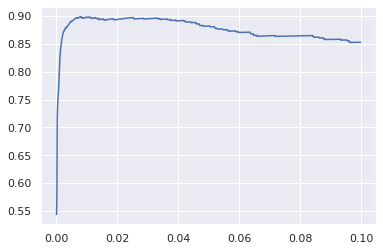

In [37]:
DF = pd.read_csv(OUTPUT_DIR+"oof_df.csv")
#ベストな閾値を探す
Threshold_list = []
f_beta_score_list = []
for i in range(1000):
    Threshold = i*0.0001
    predictions = np.where(DF["preds"] < Threshold, 0, 1)
    Threshold_list.append(Threshold)
    f_beta_score_list.append(fbeta_score(DF["judgement"], predictions, beta=7.0))
sns.set()
plt.plot(Threshold_list, f_beta_score_list)
for i,j in zip(Threshold_list, f_beta_score_list):
    if j == max(f_beta_score_list):
        print('Best Threshold :', i)
        print('Best F-Beta-Score :', j)
        break